In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random
from scipy.stats import norm, beta, triang, uniform, bernoulli, gamma
import seaborn as sns
sns.set(color_codes=True)

from scipy import stats as st# helps with many distribution functions
import numpy as np
np.set_printoptions(formatter={'float_kind':'{:f}'.format})


  1.  Write code for creating 200 simple random samples of size 30 from a population of size 1000000 that follows a beta distribution with loc=3, scale =4, 𝛼=1.5  and  𝛽=2.3 . If you consider a 96% confidence level, create the corresponding 200 confidence intervals and check with code how many trap inside the mean of the population.

Hint: you can approximate the mean and the standard deviation of the population.

In [3]:
data_beta = beta.rvs(a=1.5,b=2.3,loc=3,scale=4, size=1000000)

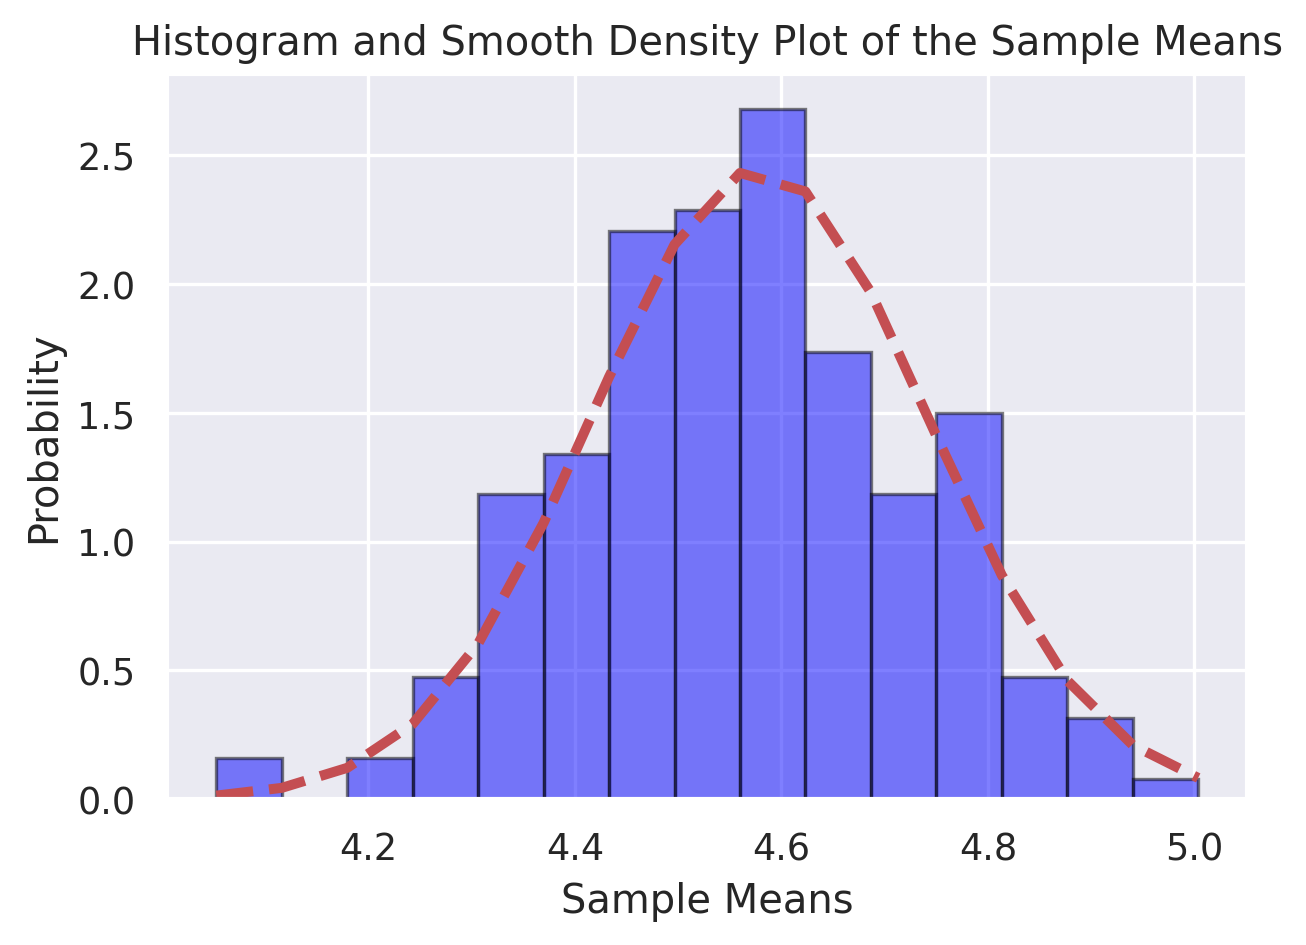

In [4]:
n = 30
means = [np.mean(np.random.choice(data_beta,n,replace=True,p=None)) for _i in range(200)]

mu = np.mean(data_beta)
sigma = np.std(data_beta)/np.sqrt(n)
num_bins = 15
n, bins, patches = plt.hist(means, num_bins, density=1, edgecolor='black',facecolor='blue', alpha=0.5)

y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--',lw=3)
plt.xlabel('Sample Means')
plt.ylabel('Probability')
plt.title(r'Histogram and Smooth Density Plot of the Sample Means')


plt.subplots_adjust(left=0.15)
plt.show()

In [5]:
inter = st.norm.interval(alpha=0.96,loc=mu,scale=sigma)
inter

(4.2444338405024835, 4.913595699653411)

In [6]:
trapped = 0
for i in means:
  if i > inter[0] and i < inter[1]:
    trapped += 1

print('Out of the 200 random samples, ' + str(trapped) +' means were trapped inside the mean of the population with 96% confidence')

Out of the 200 random samples, 192 means were trapped inside the mean of the population with 96% confidence


  2. Create a mini-casino with 5 slot machines whose such that the rewards are distributed as follows:
Machine_1: Normal distribution with mean 0.2 and standard deviation 1.1
Machine_2: Uniform distribution supported between 1 and 2.5.
Machine_3 Triangular distribution supported between 0.5 and 2, and the vertex projection splits the base 70%-30%.
Machine_4 Gamma distribution supported between -0.25 and infinity, with 𝛽 = 2/3, and 𝛼=2
Machine_5 Beta distribution supported between 0 and 2.5, with 𝛼=2.5, and 𝛽 = 2.3
Assume it costs $2 to play each machine once. Write code and apply the reinforcement learning method studied to determine the two most lucky machines.

In [23]:
def Casino(machine): # here we make a Casino with many slot machines
   
    if(machine == 1):
        return round(norm.rvs(loc=0.2,scale=1.1),2)
    
    if(machine == 2):
        return round(uniform.rvs(loc=1,scale=1.5),2)
    
    if(machine ==3 ):
        return round(triang.rvs(loc=0.5,scale=1.5,c=0.7),2)
    
    if(machine == 4):
        return round(gamma.rvs(a=2,loc=-0.25,scale=3/2),2)
    
    if(machine == 5): # this is the lucky one
        return round(beta.rvs(a=2.5,b=2.3,loc=0,scale=2.5),2)


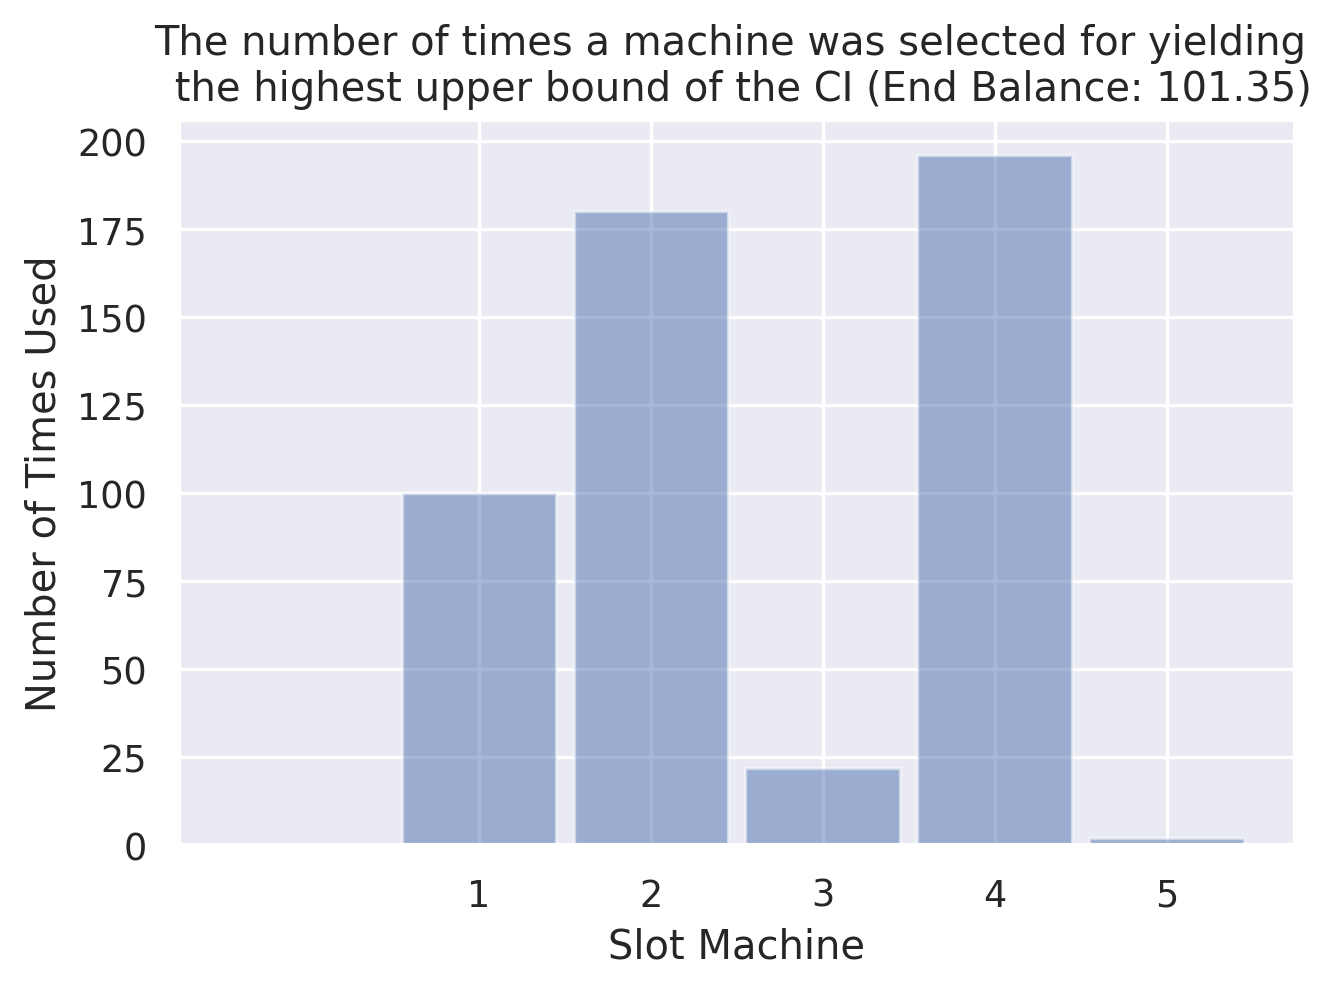

In [24]:
# this is the actual UCB algorithm
N = 500
n = 1
d = 5
machine_record = []
award_record = []
balance = 200

c = 0.9 # we can provide a "guess" for the constant (hyperparameter) c 
number_of_selections = [0] * d
sum_of_rewards = [0] * d

while n<N: # we want to play at most N times.
  machine_choice = 1
  max_upper_bound = 0
  for i in range(d):
    if (number_of_selections[i] > 0):
      average_reward = sum_of_rewards[i]/number_of_selections[i]
      E = c*np.sqrt(np.log(n)/number_of_selections[i])
      upper_bound = average_reward + E
    else:
      upper_bound = 1e200
    

    if(upper_bound >= max_upper_bound):
      max_upper_bound = upper_bound
      machine_choice = i+1 # here i+1 is because of the way Python indexes arrays
    
    # here we keep playing all machines in the order of labels 1->2->3..->20->1 but we keep track of how many times
    # a particular machine had produced the highest upper bound of the confidence interval of rewards.
    # we expect that the "lucky" machine had been selected most of the times for yielding the highest bound of the 
    # confidence interval for rewards.
    machine_record.append(machine_choice) # here we keep track of the machines played
    number_of_selections[machine_choice-1] = number_of_selections[machine_choice-1] + 1 # we also keep track of how many times we played each machine
    award = Casino(machine=machine_choice) # the oputput of the machine played
    #print(machine_choice, award)
    sum_of_rewards[machine_choice-1] = sum_of_rewards[machine_choice-1] + award # we keep track of the rewards from each machine
    balance = balance - 2 + award # here we keep track of the balance in the wallet
    n += 1

plt.hist(machine_record, bins=range(7),rwidth=0.9, alpha=0.5,align='left')
plt.title("The number of times a machine was selected for yielding \n the highest upper bound of the CI (End Balance: " + str(round(balance,2)) + ")")
plt.xlabel("Slot Machine")
plt.xticks(np.arange(1,6,1))
plt.ylabel("Number of Times Used")
plt.show()

 3. Consider the data Groceries.csv. Apply the "apriori" alorithm to determine what are the rules betweeen two items that have a minimum support of 0.005, a minimum confidence of 0.01, and a lift of at least 3.0.

In [9]:
!pip install -q apyori

In [10]:
!pip install -q pandas pyfim==6.28

     |████████████████████████████████| 357 kB 8.3 MB/s 


In [11]:
import pandas as pd
import numpy as np
from apyori import apriori 
from fim import eclat

In [47]:
data = pd.read_csv('/content/drive/MyDrive/Data310/Groceries.csv')
data.sort_values('Member_number')

,Member_number,Date,itemDescription
1629,1000,27-05-2015,soda
13331,1000,24-06-2014,whole milk
8395,1000,15-03-2015,whole milk
4843,1000,15-03-2015,sausage
17778,1000,27-05-2015,pickled vegetables
...,...,...,...
34885,5000,10-02-2015,semi-finished bread
25489,5000,16-11-2014,other vegetables
9340,5000,16-11-2014,bottled beer
27877,5000,09-03-2014,onions


In [49]:

data['cols'] = data.groupby('Date').cumcount()
selected_pivot = data.pivot(index = 'Date',columns = 'cols')[['itemDescription']]
selected_pivot

itemDescription                                       \
cols                      0                 1                  2    
Date                                                                
01-01-2014           cleaner           sausage     tropical fruit   
01-01-2015       canned beer      frozen meals             butter   
01-02-2014  other vegetables         pip fruit        frankfurter   
01-02-2015        whole milk       canned beer      bottled water   
01-03-2014           sausage              meat              sugar   
...                      ...               ...                ...   
31-07-2015           vinegar           chicken    root vegetables   
31-08-2014              pork  other vegetables               beef   
31-08-2015       brown bread       frankfurter            chicken   
31-10-2014            yogurt       frankfurter   other vegetables   
31-10-2015           chicken       canned beer  frozen vegetables   

                                                                \
cols                  3                 4                   5    
Date                                                             
01-01-2014    whole milk      citrus fruit              onions   
01-01-2015           ham      citrus fruit      tropical fruit   
01-02-2014         sugar  other vegetables   frozen vegetables   
01-02-2015          soda        whole milk    other vegetables   
01-03-2014       sausage      bottled beer          whole milk   
...                  ...               ...                 ...   
31-07-2015       chicken           sausage  whipped/sour cream   
31-08-2014    whole milk  hygiene articles          whole milk   
31-08-2015  citrus fruit           berries          whole milk   
31-10-2014   salty snack     sweet spreads              pastry   
31-10-2015          beef       canned beer             chicken   

                                                                       \
cols                      6                 7                      8    
Date                                                                    
01-01-2014  other vegetables           berries         hamburger meat   
01-01-2015           dessert        whole milk         tropical fruit   
01-02-2014              beef           waffles                   beef   
01-02-2015        whole milk       canned beer              pip fruit   
01-03-2014  other vegetables   root vegetables  fruit/vegetable juice   
...                      ...               ...                    ...   
31-07-2015           sausage  other vegetables            canned beer   
31-08-2014    hamburger meat   root vegetables       other vegetables   
31-08-2015        rolls/buns        whole milk                    ham   
31-10-2014     specialty bar   root vegetables             white wine   
31-10-2015    tropical fruit     bottled water           frozen meals   

                              ...                                          \
cols                      9   ...   86   87   88   89   90   91   92   93   
Date                          ...                                           
01-01-2014    hamburger meat  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
01-01-2015       frankfurter  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
01-02-2014              meat  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
01-02-2015    tropical fruit  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
01-03-2014              soda  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
31-07-2015            dishes  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
31-08-2014  other vegetables  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
31-08-2015      citrus fruit  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
31-10-2014   root vegetables  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
31-10-2015    tropical fruit  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                   

In [62]:
purchases = []
for i in range(0,len(selected_pivot)):
    purchases.append([str(selected_pivot.values[i,j]) for j in range(0,95)])

In [63]:
rules = apriori(purchases, min_support = .005, min_confidence = 0.01, min_lift=3, max_length = 2) 

In [64]:
results = list(rules)
print(results)

[RelationRecord(items=frozenset({'cleaner', 'abrasive cleaner'}), support=0.005494505494505495, ordered_statistics=[OrderedStatistic(items_base=frozenset({'abrasive cleaner'}), items_add=frozenset({'cleaner'}), confidence=0.18181818181818182, lift=4.564263322884013), OrderedStatistic(items_base=frozenset({'cleaner'}), items_add=frozenset({'abrasive cleaner'}), confidence=0.13793103448275865, lift=4.564263322884013)]), RelationRecord(items=frozenset({'baking powder', 'decalcifier'}), support=0.008241758241758242, ordered_statistics=[OrderedStatistic(items_base=frozenset({'baking powder'}), items_add=frozenset({'decalcifier'}), confidence=0.05454545454545455, lift=4.412121212121213), OrderedStatistic(items_base=frozenset({'decalcifier'}), items_add=frozenset({'baking powder'}), confidence=0.6666666666666667, lift=4.412121212121213)]), RelationRecord(items=frozenset({'sauces', 'canned fruit'}), support=0.005494505494505495, ordered_statistics=[OrderedStatistic(items_base=frozenset({'canne

In [65]:
rules = 0
for i in range(0,len(results)): 
    result = results[i]
    supp   = int(result.support*10000)/100
    conf   = int(result.ordered_statistics[0].confidence*100)
    hypo   = ''.join([x+' ' for x in result.ordered_statistics[0].items_base])
    conc   = ''.join([x+' ' for x in result.ordered_statistics[0].items_add if x!='nan'])
    if "nan" not in hypo:
        rules = rules + 1
        print("If "+str(hypo)+" is purchased, " +str(conf)+" % of the time " + str(conc)+" is purchased [support - " +str(supp)+"%]")
print("Total rules built : " +str(rules))

If abrasive cleaner  is purchased, 18 % of the time cleaner  is purchased [support - 0.54%]
If baking powder  is purchased, 5 % of the time decalcifier  is purchased [support - 0.82%]
If canned fruit  is purchased, 19 % of the time sauces  is purchased [support - 0.54%]
If cereals  is purchased, 9 % of the time cookware  is purchased [support - 0.54%]
If cleaner  is purchased, 13 % of the time rum  is purchased [support - 0.54%]
If cocoa drinks  is purchased, 31 % of the time finished products  is purchased [support - 0.68%]
If curd cheese  is purchased, 11 % of the time light bulbs  is purchased [support - 0.68%]
If decalcifier  is purchased, 44 % of the time pet care  is purchased [support - 0.54%]
If female sanitary products  is purchased, 10 % of the time honey  is purchased [support - 0.54%]
If female sanitary products  is purchased, 12 % of the time prosecco  is purchased [support - 0.68%]
If female sanitary products  is purchased, 17 % of the time softener  is purchased [support